In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import symmetric_methods as sm


In [ ]:
L=2

dim = np.zeros((L+1,))

dim[0] = 100
dim[1] = 10000
dim[2] = 100
#dim[3] = 6
#dim[4] = 7
#dim[5] = 5

dim= dim.astype(int)

npar = 0
cpar = np.zeros((L+1,))
for iL in range(L):
    npar = npar + dim[iL] * dim[iL+1]
    cpar[iL+1] = npar
npar = npar.astype(int)
cpar = cpar.astype(int)

print(npar)
    
num_train_data = 10000
num_test_data = 10000

#num_train_data = 150
#num_test_data = 150

noise = 0

### Create Neural Network

In [ ]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(dim[0],dim[1],bias=False)]
        for iL in np.arange(1,L):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(dim[iL],dim[iL+1],bias=False))        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



# Define a custom initialization function using Gaussian distribution
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Gaussian initialization 
        y = m.in_features
        nn.init.normal_(m.weight, mean=0.0, std=1/np.sqrt(y)) 


net_teacher = Net()
net_teacher.apply(initialize_weights)

net = Net()
net.apply(initialize_weights)

net0 = Net()
net0.load_state_dict(net.state_dict())

num_parameters = sum(param.numel() for param in net.parameters())
print(num_parameters)


In [ ]:
# print list of all parameter tensors
print(list(net.parameters()))

### Input data

In [ ]:
# gradient on linear regression has D ~ (unif)^(1/(1-beta)) --> p(D) ~ D^(-beta) --> Loss(t) ~ t^(beta-2)

D = np.logspace(0,-5,dim[0])
#D = 1./(np.linspace(1,1000,dim[0])**2)
#D = np.linspace(0,1,dim[0])**2

Sigma, R = np.linalg.qr(np.random.normal(np.zeros((dim[0],dim[0])),1))
Sigma = (Sigma * D) @ Sigma.T
inputs_train = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_train_data,))).to(torch.float)
inputs_test = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_test_data,))).to(torch.float)



### Output data

In [ ]:

# teacher - student

with torch.no_grad():
    labels_train = net_teacher(inputs_train) + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
with torch.no_grad():
    labels_test = net_teacher(inputs_test) + torch.from_numpy(noise * np.random.normal(np.zeros((num_test_data,dim[L])),1)).to(torch.float)




### Gradient statistics

In [ ]:

N = 1000
num_updates = 0
learning_rate = 0.01

grad_rec = torch.zeros(num_parameters,N)

lossavg = torch.zeros(num_updates+1,)

for iN in np.arange(0,N):
    
    if (iN+1)%(N/100)==0:
        print(iN+1)
    
    net.apply(initialize_weights)

    # Forward pass
    outputs_train = net(inputs_train)

    # Compute the loss
    loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
    with torch.no_grad():
        lossavg[0] = lossavg[0] + loss

    # Compute first-order gradients (Jacobian)
    grads = torch.autograd.grad(loss, net.parameters())        
        
    for upd in range(num_updates):
        
        with torch.no_grad():  # Disable gradient computation for manual update
            for param, grad in zip(net.parameters(), grads):
                param -= learning_rate * grad
    
        outputs_train = net(inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
        grads = torch.autograd.grad(loss, net.parameters())
        
        with torch.no_grad():
            lossavg[upd+1] = lossavg[upd+1] + loss
    
    # Flatten gradients of all tensors (in column major order, Fortran style!)
    grad_all = torch.cat([g.T.reshape(-1,1) for g in grads])
    grad_rec[:,iN] =  torch.squeeze(grad_all)
    


In [ ]:

#PATH = './grad_Tanh_100_10_100_N1000_t00.pt'
#PATH = './grad_Tanh_100_100_100_N1000_t00.pt'
#PATH = './grad_Tanh_100_1000_100_N1000_t00.pt'
#PATH = './grad_Tanh_100_10000_100_N1000_t00.pt'

#PATH = './grad_Tanh_100_10_100_N10000_t00.pt'
#PATH = './grad_Tanh_100_100_100_N10000_t00.pt'
#PATH = './grad_Tanh_100_1000_100_N10000_t00.pt'

#PATH = './grad_Tanh_10_10_10_N1000_t00.pt'
#PATH = './grad_Tanh_10_100_10_N1000_t00.pt'
#PATH = './grad_Tanh_10_1000_10_N1000_t00.pt'
#PATH = './grad_Tanh_10_10000_10_N1000_t00.pt'

#PATH = './grad_Tanh_10_10_10_N10000_t00.pt'
#PATH = './grad_Tanh_10_100_10_N10000_t00.pt'
#PATH = './grad_Tanh_10_1000_10_N10000_t00.pt'
#PATH = './grad_Tanh_10_10000_10_N10000_t00.pt'

#PATH = './grad_Tanh_10_10_10_N100000_t00.pt'

#torch.save({'L':L, 'dim':dim, 'D':D, 'num_train_data':num_train_data, 'num_test_data':num_test_data, 'noise':noise, 'learning_rate':learning_rate, 'N':N, 'lossavg':lossavg, 'num_updates':num_updates, 'grad_rec':grad_rec}, PATH)




In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import symmetric_methods as sm


In [2]:


#dic = torch.load('grad_Tanh_10_100_10_N1000_t00.pt')
#dic = torch.load('grad_Tanh_10_1000_10_N1000_t00.pt')
#dic = torch.load('grad_Tanh_10_10000_10_N1000_t00.pt')

#dic = torch.load('grad_Tanh_10_10_10_N10000_t00.pt')
#dic = torch.load('grad_Tanh_10_100_10_N10000_t00.pt')
#dic = torch.load('grad_Tanh_10_1000_10_N10000_t00.pt')
#dic = torch.load('grad_Tanh_10_10000_10_N10000_t00.pt')

#dic = torch.load('grad_Tanh_10_10_10_N100000_t00.pt')




#dic = torch.load('grad_Tanh_100_10_100_N10000_t00.pt')
#dic = torch.load('grad_Tanh_100_100_100_N10000_t00.pt')
#dic = torch.load('grad_Tanh_100_1000_100_N10000_t00.pt')

#dic = torch.load('grad_Tanh_100_10_100_N1000_t00.pt')
#dic = torch.load('grad_Tanh_100_100_100_N1000_t00.pt')
dic = torch.load('grad_Tanh_100_1000_100_N1000_t00.pt')
#dic = torch.load('grad_Tanh_100_10000_100_N1000_t00.pt')


L = dic['L']
dim = dic['dim']
D = dic['D']
num_train_data = dic['num_train_data']
num_test_data = dic['num_test_data']
noise = dic['noise']
learning_rate = dic['learning_rate']
N = dic['N']
lossavg = dic['lossavg']
num_updates = dic['num_updates']
grad_rec = dic['grad_rec']


In [3]:
# "Ground truth" is defined as the factors obtained by using all N models


phi,PHI1,PSI1,PHIL = sm.grad2par(L,dim,grad_rec)

allfactors = np.concatenate((phi.flatten(order='F'),PHI1.flatten(order='F'),PSI1.flatten(order='F'),PHIL.flatten(order='F')))
num_factors = allfactors.shape[0]
num_phi = phi.flatten(order='F').shape[0]
num_PHI1 = PHI1.flatten(order='F').shape[0]
num_PSI1 = PSI1.flatten(order='F').shape[0]
num_PHIL = PHIL.flatten(order='F').shape[0]



In [4]:
# Estimated factors from a sample of M models

M=1

allfactors_est = np.zeros((N,num_factors))
phivec = np.zeros((N,num_phi))
PHI1vec = np.zeros((N,num_PHI1))
PSI1vec = np.zeros((N,num_PSI1))
PHILvec = np.zeros((N,num_PHIL))
for iN in np.arange(0,N):    
    if (iN+1)%(N/100)==0:
        print(iN+1)
    grad_now = np.zeros((grad_rec.shape[0],1))
    grad_now[:,0] = grad_rec[:,iN]
    phiest,PHI1est,PSI1est,PHILest = sm.grad2par(L,dim,grad_now)
    allfactors_est[iN,:] = np.concatenate((phiest.flatten(order='F'),PHI1est.flatten(order='F'),PSI1est.flatten(order='F'),PHILest.flatten(order='F')))
    phivec[iN,:] = phiest.flatten(order='F')
    PHI1vec[iN,:] = PHI1est.flatten(order='F')
    PSI1vec[iN,:] = PSI1est.flatten(order='F')
    PHILvec[iN,:] = PHILest.flatten(order='F')





10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


In [5]:

comparison = np.zeros((2,num_factors))
comparison[0,:] = allfactors
corrcoef = np.zeros((N,))
for iN in np.arange(0,N):    
    comparison[1,:] = allfactors_est[iN,:]   
    corrmat = np.corrcoef(comparison)
    corrcoef[iN] = corrmat[0,1]


comparison_PHI1 = np.zeros((2,num_PHI1))
comparison_PHI1[0,:] = PHI1.flatten(order='F')
corrcoef_PHI1 = np.zeros((N,))
for iN in np.arange(0,N):    
    comparison_PHI1[1,:] = PHI1vec[iN,:]    
    corrmat = np.corrcoef(comparison_PHI1)
    corrcoef_PHI1[iN] = corrmat[0,1]


comparison_PSI1 = np.zeros((2,num_PSI1))
comparison_PSI1[0,:] = PSI1.flatten(order='F')
corrcoef_PSI1 = np.zeros((N,))
for iN in np.arange(0,N):    
    comparison_PSI1[1,:] = PSI1vec[iN,:]  
    corrmat = np.corrcoef(comparison_PSI1)
    corrcoef_PSI1[iN] = corrmat[0,1]


comparison_PHIL = np.zeros((2,num_PHIL))
comparison_PHIL[0,:] = PHIL.flatten(order='F')
corrcoef_PHIL = np.zeros((N,))
for iN in np.arange(0,N):    
    comparison_PHIL[1,:] = PHILvec[iN,:]    
    corrmat = np.corrcoef(comparison_PHIL)
    corrcoef_PHIL[iN] = corrmat[0,1]




0.544156507792284
0.02580873323332514


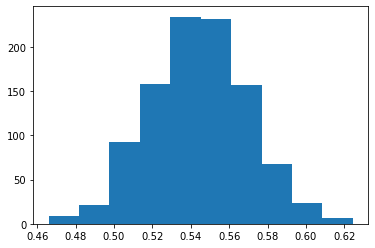

0.9578907541131412
0.009421427084848465


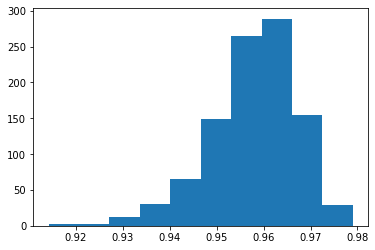

0.6359184690140792
0.02729196232855488


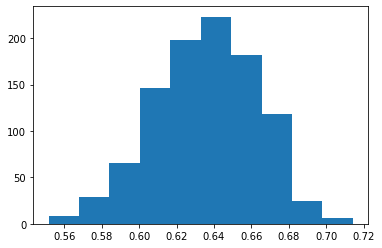

0.5372753790798088
0.02636565124181022


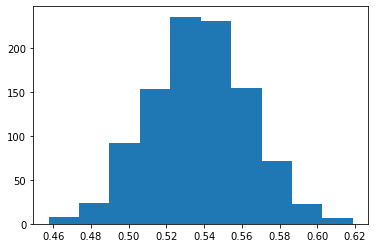

In [6]:
#np.fill_diagonal(corrmat, np.nan)
#corravg[epoch] = np.nanmean(corrmat)
#meanpar[epoch] = np.mean(allmodels)



print(np.mean(corrcoef))
print(np.std(corrcoef))
plt.hist(corrcoef)
plt.show()

print(np.mean(corrcoef_PHI1))
print(np.std(corrcoef_PHI1))
plt.hist(corrcoef_PHI1)
plt.show()

print(np.mean(corrcoef_PSI1))
print(np.std(corrcoef_PSI1))
plt.hist(corrcoef_PSI1)
plt.show()

print(np.mean(corrcoef_PHIL))
print(np.std(corrcoef_PHIL))
plt.hist(corrcoef_PHIL)
plt.show()



In [7]:

# Frobenius norms

print(np.linalg.norm(PHI1))
print(np.linalg.norm(PSI1))
print(np.linalg.norm(PHIL))



0.0023651563
0.0010920265
0.012880523


In [ ]:

# grad_Tanh_10_10_10_N1000_t00
# m: 0.7236042295732029 sd: 0.13221594235382866

# grad_Tanh_10_100_10_N1000_t00
# m: 0.5118464886047205 sd: 0.14811294039175948

# grad_Tanh_10_1000_10_N1000_t00
# m: 0.5600372275565779 sd: 0.15113882077697227

# grad_Tanh_10_10000_10_N1000_t00
# m: 0.7039038878651555 sd: 0.12663220761704194





# grad_Tanh_10_10_10_N10000_t00
# m: 0.745766485644828 sd: 0.13562188621954518

# grad_Tanh_10_100_10_N10000_t00
# m: 0.6328305687888105 sd: 0.14358955760798586

# grad_Tanh_10_1000_10_N10000_t00
# m: 0.5792602346518047 sd: 0.15408718992030593

# grad_Tanh_10_10000_10_N10000_t00
# m: 0.6354638589255917 sd: 0.1436364007609975




# grad_Tanh_10_10_10_N100000_t00
# m: 0.7743878792980576 sd: 0.1300062622456797








# grad_Tanh_100_10_100_N1000_t00
# m: 0.6640723762637484 sd: 0.051171139466877194
# block_11   0.6724398924950928   0.051721885745126386      norm 1.068446
# block_12   0.37868593496100983  0.05938406655910858       norm 0.11188086
# block_22   0.30332930444985184  0.04658981341488104       norm 0.020284323

# grad_Tanh_100_100_100_N1000_t00
# m: 0.7515054710863999 sd: 0.026231373426622392      
# block_11   0.8977341240368342   0.021533886372366015      norm 0.032072607
# block_12   0.6139786677213157   0.03756047913969513       norm 0.011326098
# block_22   0.5207547443236414   0.03488333209030957       norm 0.014900369


# grad_Tanh_100_1000_100_N1000_t00
# m: 0.544156507792284 sd: 0.02580873323332514
# block_11   0.9578907541131412   0.009421427084848465      norm 0.0023651563
# block_12   0.6359184690140792   0.02729196232855488       norm 0.0010920265
# block_22   0.5372753790798088   0.02636565124181022       norm 0.012880523

# grad_Tanh_100_10000_100_N1000_t00
# m: 0.5609152113386956 sd: 0.026267845481244917
# block_11   0.9670925601973681   0.006982811418187577      norm 0.00022690624
# block_12   0.6481548793729387   0.02787282945314115       norm 0.00010831969
# block_22   0.5605243164027293   0.026320928610400734      norm 0.013112202



# grad_Tanh_100_10_100_N10000_t00
# m: 0.6630072873359619 sd: 0.05406491408083349

# grad_Tanh_100_100_100_N10000_t00
# m: 0.7404478604596846 sd: 0.024992079652419112

# grad_Tanh_100_1000_100_N10000_t00
# m: 0.5508080607720766 sd: 0.02356322285854846










In [ ]:

#plt.plot(covg2,covg2est,linestyle='none',marker='.')
#plt.plot([np.min(covg2), np.max(covg2)],[np.min(covg2), np.max(covg2)])
#plt.show()

#plt.scatter(phi,phiest,s=1)
#plt.scatter(PHI1,PHI1est,s=1)
#plt.scatter(PSI1,PSI1est,s=1)
plt.scatter(PHIL,PHILest,s=1)
#plt.plot([-100, 300],[-100, 300])
plt.show()


print(phi)
print('\n')
print(phiest)
print('\n')
print(PHI1)
print('\n')
print(PHI1est)
print('\n')
print(PSI1)
print('\n')
print(PSI1est)
print('\n')
print(PHIL)
print('\n')
print(PHILest)



In [ ]:

print(dim)
print(N)

